## **b-tagging efficiency**

The b-tagging weights are computed as 

$$w = \prod_{i=\text{tagged}} \frac{SF_{i} \cdot \varepsilon_i}{\varepsilon_i} \prod_{j=\text{not tagged}} \frac{1 - SF_{j} \cdot \varepsilon_j}{1-\varepsilon_j} $$

where $ \varepsilon_i $ is the MC b-tagging efficiency, and $ \text{SF}_i $ and $ \varepsilon_i $ are, as usual, functions of the jet flavor, jet $ p_\text{T} $, and jet $ \eta $. 

To obtain the b-tagging efficiency, we begin by defining a processor (`btag_efficiency_processor`) that fills the following histogram using all MC samples in the analysis


```
hist.Hist(
    hist.axis.StrCategory([], growth=True, name="dataset"),
    hist.axis.Variable([20, 30, 50, 70, 100, 140, 200, 300, 600, 1000], name="pt"),
    hist.axis.Regular(4, 0, 2.5, name="abseta"),
    hist.axis.IntCategory([0, 4, 5], name="flavor"),
    hist.axis.Regular(2, 0, 2, name="passWP"),
)
```

where `passWP` is a flag use to know if the jet pass the working point used.

Let's begin by loading the output of the processor

In [3]:
import pickle
import glob
import numpy as np
import importlib.resources
import matplotlib.pyplot as plt
from coffea import processor
from coffea import util
from coffea.lookup_tools.dense_lookup import dense_lookup

output_path = "..."
with open(f"{output_path}/*.pkl", "rb") as f:
    btag_efficiency_hist = pickle.load(f)
    
btag_efficiency_hist

Hist(
  StrCategory(['DYJetsToLL_M-50_HT-100to200', 'TTTo2L2Nu', 'ST_t-channel_top_5f_InclusiveDecays', 'ST_tW_top_5f_inclusiveDecays', 'ST_tW_antitop_5f_inclusiveDecays', 'ST_t-channel_top_4f_InclusiveDecays', 'ST_t-channel_antitop_5f_InclusiveDecays', 'ST_t-channel_antitop_4f_InclusiveDecays', 'DYJetsToLL_M-50_HT-400to600', 'ST_s-channel_4f_leptonDecays', 'DYJetsToLL_M-50_HT-800to1200', 'DYJetsToLL_M-50_HT-600to800', 'DYJetsToLL_M-50_HT-2500toInf', 'DYJetsToLL_M-50_HT-200to400', 'DYJetsToLL_M-50_HT-1200to2500', 'WJetsToLNu_HT-400To600', 'WJetsToLNu_HT-600To800', 'ZZ', 'WZ', 'WW', 'WJetsToLNu_HT-800To1200', 'WJetsToLNu_HT-200To400', 'WJetsToLNu_HT-2500ToInf', 'WJetsToLNu_HT-100To200', 'WJetsToLNu_HT-1200To2500', 'TTToSemiLeptonic', 'TTToHadronic'], growth=True, name='dataset'),
  Variable([20, 30, 50, 70, 100, 140, 200, 300, 600, 1000], name='pt'),
  Regular(4, 0, 2.5, name='abseta'),
  IntCategory([0, 4, 5], name='flavor'),
  Regular(2, 0, 2, name='passWP'),
  storage=Double()) # Sum

Now, let us accumulate all the samples and compute the efficiency

In [4]:
acc_btag_efficiency_hist = btag_efficiency_hist[{"dataset": sum}]
efficiency = acc_btag_efficiency_hist[{"passWP": True}] / acc_btag_efficiency_hist[{"passWP": sum}]

From this, we can create a lookup table 

In [5]:
efflookup = dense_lookup(efficiency.values(), [ax.edges for ax in efficiency.axes]) 
efflookup

3 dimensional histogram with axes:
	1: [  20.   30.   50.   70.  100.  140.  200.  300.  600. 1000.]
	2: [0.    0.625 1.25  1.875 2.5  ]
	3: [0. 1. 2. 3.]

In [6]:
# Efficiency at 43 GeV, |eta|=0.2, for light, c, and b quark respectively
efflookup(43, 0.1, np.array([0, 1, 2]))

array([0.01676625, 0.17308243, 0.81435029])

Notice that hadron flavours (0, 4, 5) turn into (0, 1, 2). Let's modify them to their original values

In [7]:
efflookup._axes[-1] = np.array([0., 4., 5., 6.]) 

In [8]:
# Efficiency at 43 GeV, |eta|=0.2, for light, c, and b quark respectively
efflookup(43, 0.1, np.array([0, 4, 5]))

array([0.01676625, 0.17308243, 0.81435029])

Let's visualize these efficiencies for the three flavors

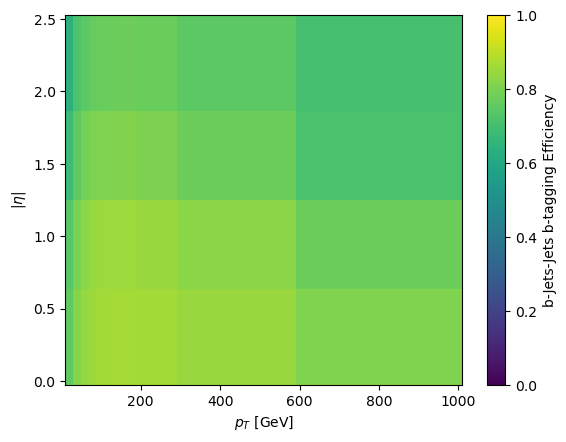

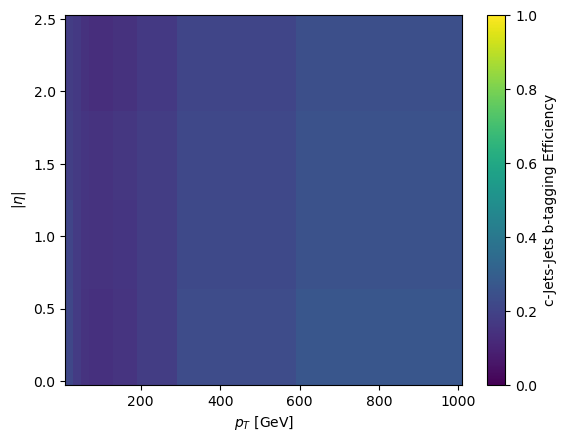

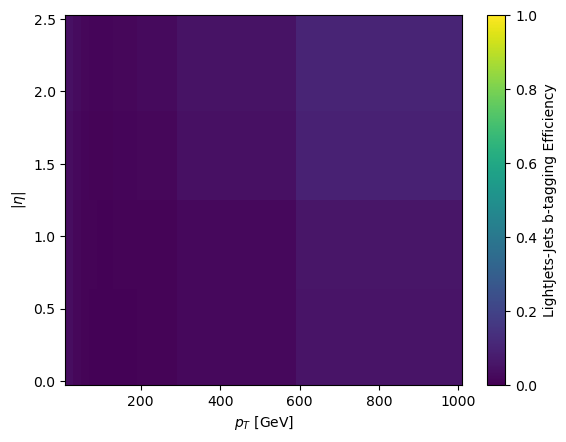

In [9]:
pts = np.linspace(20, 1000)
etas = np.linspace(0, 2.5)
pt, eta = np.meshgrid(pts, etas)

flavor_tags = {0: "LightJets", 4: "c-Jets", 5: "b-Jets"}
for i, flavor in enumerate([5, 4, 0]):
    fig, ax = plt.subplots()
    heatmap = ax.pcolormesh(pt, eta, efflookup(pt, eta, flavor), cmap='viridis', vmin=0, vmax=1)
    cbar = fig.colorbar(heatmap)
    ax.set_xlabel('$p_T$ [GeV]')
    ax.set_ylabel('$|\eta|$')
    cbar.set_label(f'{flavor_tags[flavor]}-Jets b-tagging Efficiency')

Let's save this efficiency lookup table for later use in the computation of the b-tagging weights

In [8]:
output_path = "wprime_plus_b/data/btag_eff_deepJet_M_2017.coffea"
util.save(efflookup, output_path)